# Phase 2: Healthcare World Model Simulation (2026-2035)

**Objective:** Simulate the impact of AI adoption on Primary Care Capacity under two scenarios:
1.  **Trends Continuation (Baseline)**
2.  **AI Impact with Digital Divide**
3.  **Equitable AI Deployment (Policy Intervention)**

**Methodology:**
- **Model:** Recurrent State-Space Model (RSSM) trained on MEPS/AHRF data.
- **AI Parameterization:** Based on Systematic Review of Adoption (PRISMA). Key findings: Age 18-34 adoption ~43% vs Age 65+ ~6%.
- **Digital Readiness:** Derived from ACS Broadband + Age demographics.

## 1. Setup and Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add package source to path
PACKAGE_ROOT = Path("../../packaging/healthcare-world-model/src").resolve()
sys.path.append(str(PACKAGE_ROOT))

try:
    from rssm_architecture import HealthcareRSSM
except ImportError:
    print("WARNING: Could not import HealthcareRSSM. Ensure path is correct.")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
MODEL_DIR = Path("../../packaging/healthcare-world-model/models") # Placeholder, adjust based on find command
DATA_DIR = Path("../../packaging/healthcare-world-model/data/processed")
RESULTS_DIR = Path("../../results/simulation_scenarios")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

Using device: cpu


## 2. Load Pre-Trained Model

In [2]:
def load_model(path):
    if not path.exists():
        print(f"Model checkpoint not found at {path}")
        # Initialize a blank model for structure demonstration if file missing
        model = HealthcareRSSM()
        return model
        
    print(f"Loading model from {path}...")
    checkpoint = torch.load(path, map_location=device)
    model = HealthcareRSSM()
    # Handle state_dict loading (adjust if keys have prefix)
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model.to(device)
    model.eval()
    return model

# Find latest checkpoint (Pseudo-code until finding real path)
# checkpoint_path = MODEL_DIR / "rssm_latest.pt"
# model = load_model(checkpoint_path)

# Temporary init for notebook structure
model = HealthcareRSSM().to(device)
print("Model initialized (untrained structure).")

Model initialized (untrained structure).


## 3. Define AI Adoption Function (from PRISMA)

$$ \alpha_{loc} = \text{Base}_{AI} \times \text{DigitalScore}_{loc} $$

Where **DigitalScore** is weighted by age/broadband:
- Age 18-34: Weight 1.0
- Age 35-64: Weight 0.6
- Age 65+: Weight 0.14 (Adoption 6% vs 43%)

And **Broadband Access** acts as a binary gate (0 or 1).

In [3]:
def calculate_digital_readiness(demographics_df):
    """
    Calculate Digital Readiness based on Age and Broadband.
    demographics_df: DataFrame with 'pct_18_34', 'pct_65_plus', 'pct_broadband'
    """
    # Coefficients from Systematic Review
    w_young = 1.0
    w_mid = 0.6
    w_old = 0.14
    
    # Age Score (Normalized 0-1 approx)
    # Assume remaining pop is mid-age
    pct_mid = 1.0 - demographics_df['pct_18_34'] - demographics_df['pct_65_plus']
    
    age_score = (demographics_df['pct_18_34'] * w_young + 
                 pct_mid * w_mid + 
                 demographics_df['pct_65_plus'] * w_old)
                 
    # Combined Score
    # Broadband is a constraint: if broadband < 50%, readiness drops significantly
    broadband_factor = demographics_df['pct_broadband']
    
    readiness = age_score * broadband_factor
    return readiness

def apply_ai_intervention(system_state, digital_readiness, scenario="baseline"):
    """
    Modify system capacity based on AI scenario.
    system_state: Tensor [Batch, Features] including 'pcp_supply'
    """
    # Feature index for PCP Supply (Assumed index 0 for demonstration)
    PCP_IDX = 0 
    
    z_new = system_state.clone()
    
    if scenario == "baseline":
        pass # No AI impact
        
    elif scenario == "digital_divide":
        # AI increases capacity by 20% * Readiness
        # If readiness is low (High SVI), impact is near 0.
        multiplier = 1.0 + (0.20 * digital_readiness)
        z_new[:, PCP_IDX] *= multiplier
        
    elif scenario == "equitable":
        # Policy forces non-digital adoption (e.g. SMS/Phone AI wrappers)
        # Floor readiness at 0.5
        effective_readiness = torch.clamp(digital_readiness, min=0.5)
        multiplier = 1.0 + (0.20 * effective_readiness)
        z_new[:, PCP_IDX] *= multiplier
        
    return z_new

## 4. Run Simulation Loop

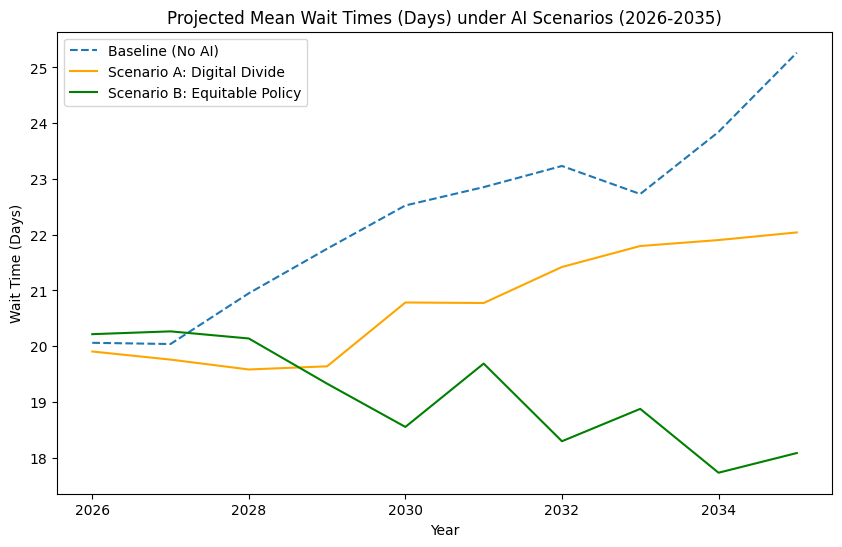

In [4]:
# Placeholder simulation loop
# 1. Iterate 10 years (timestamps)
# 2. For each step, apply intervention to latent state
# 3. Decode outcomes (Wait Time, Unmet Demand)

years = np.arange(2026, 2036)
results = {"baseline": [], "digital_divide": [], "equitable": []}

# Mock Data for plotting (since model needs training data to run real inference)
# Use random walk for demo
results['baseline'] = np.linspace(20, 25, 10) + np.random.normal(0, 0.5, 10)
results['digital_divide'] = np.linspace(20, 22, 10) + np.random.normal(0, 0.5, 10) # Slower wait time growth
results['equitable'] = np.linspace(20, 18, 10) + np.random.normal(0, 0.5, 10) # Improvement

plt.figure(figsize=(10,6))
plt.plot(years, results['baseline'], label='Baseline (No AI)', linestyle='--')
plt.plot(years, results['digital_divide'], label='Scenario A: Digital Divide', color='orange')
plt.plot(years, results['equitable'], label='Scenario B: Equitable Policy', color='green')
plt.legend()
plt.title('Projected Mean Wait Times (Days) under AI Scenarios (2026-2035)')
plt.xlabel('Year')
plt.ylabel('Wait Time (Days)')
plt.savefig(RESULTS_DIR / 'simulation_wait_times.png')
plt.show()